[Enlace](https://machinelearningmastery.com/xgboost-for-time-series-forecasting/)

In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
import matplotlib.pyplot as plt

## Time series data preparation

In [2]:
# Transform a time series dataset into a supervised learning dataset

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    '''
    Convierte una serie de tiempo en un conjunto de datos de aprendizaje supervisado.
    Argumentos:
        data: Secuencia de observaciones como una lista o un DataFrame.
        n_in: Número de observaciones retrasadas como entrada (X).
        n_out: Número de observaciones como salida (Y).
        dropnan: Booleano que indica si se deben eliminar las filas con valores NaN.
    Devuelve:
        DataFrame de pandas de la serie enmarcada para aprendizaje supervisado.

    '''
    # Si los datos son una lista, n_vars será 1, de lo contrario será el número de características (columnas) en el conjunto de datos
    n_vars = 1 if type(data) is list else data.shape[1]
    # Convierte los datos en DataFrame
    df = pd.DataFrame(data)
    # Inicializa una lista para guardar los datos
    cols = list()

    # Construye la secuencia de entrada, Input sequence (t-n, ..., t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    
    # Construye la secuencia de pronóstico, Forecast sequence (t, t+1, ..., t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))

    # Concatena todas las columnas
    agg = pd.concat(cols, axis=1)

    # Elimina filas con valores NaN
    if dropnan:
        agg.dropna(inplace=True)
    
    return agg.values

**Descripción de la función :**

1. `series_to_supervised(data, n_in=1, n_out=1, dropnan=True)`: Esta función convierte una serie temporal en un conjunto de datos de aprendizaje supervisado. El argumento 'data' se refiere a la serie temporal de entrada, 'n_in' es el número de pasos de tiempo como entrada (X), y 'n_out' es el número de pasos de tiempo a predecir (Y). 'dropnan' es un booleano que determina si se deben eliminar o no los valores NaN.

2. `n_vars = 1 if type(data) is list else data.shape[1]`: Esta línea determina el número de variables de entrada. Si 'data' es una lista, entonces hay una variable. De lo contrario, el número de variables es el número de columnas en los datos.

3. `df = DataFrame(data)`: Aquí se convierte la serie temporal de entrada 'data' en un DataFrame de pandas.

4. `cols = list()`: Aquí se inicializa una lista vacía para guardar las columnas del DataFrame de salida.

5. `for i in range(n_in, 0, -1): cols.append(df.shift(i))`: Este bucle crea las columnas de entrada (X) en el DataFrame de salida. Cada columna es una versión desplazada de la serie temporal de entrada.

6. `for i in range(0, n_out): cols.append(df.shift(-i))`: Este bucle crea las columnas de salida (Y) en el DataFrame de salida. Cada columna es una versión desplazada de la serie temporal de entrada.

7. `agg = concat(cols, axis=1)`: Aquí se concatena todas las columnas en un solo DataFrame.

8. `if dropnan: agg.dropna(inplace=True)`: Esta línea elimina cualquier fila con valores NaN si 'dropnan' es True.

9. `return agg.values`: Finalmente, la función devuelve los valores del DataFrame de salida como una matriz numpy.

In [15]:
# Split a univariate dataset into train-test sets

def train_test_split(data, n_test):
    """
    Divide un conjunto de datos univariante en conjuntos de entrenamiento y prueba.
    Argumentos:
        data: Conjunto de datos completo.
        n_test: Número de observaciones a usar para el conjunto de prueba.
    Devuelve:
        Tuple de los conjuntos de datos de entrenamiento y prueba.
    """
    return data[:-n_test, :], data[-n_test:, :]

In [16]:
# Fit an XBGoost model and make a one step prediction

def xgboost_forecast(train, testX):
    """
    Ajusta un modelo XGBoost y realiza una predicción de un solo paso.
    Argumentos:
        train: Conjunto de datos de entrenamiento.
        testX: Entrada para la cual hacer la predicción.
    Devuelve:
        La predicción de un solo paso para testX.
    """
    
    # Transforma la lista en una matriz
    train = np.asarray(train)
    
    # Divide en columnas de entrada y salida
    trainX, trainy = train[:, :-1], train[:, -1]
    
    # Ajusta el modelo
    model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
    model.fit(trainX, trainy)
    
    # Realiza una predicción de un solo paso
    yhat = model.predict([testX])
    return yhat[0]

In [17]:
# Walk-forvar validation for univariate data

def walk_forward_validation(data, n_test):
    """
    Realiza la validación hacia adelante en datos univariantes.
    Argumentos:
        data: Conjunto de datos completo.
        n_test: Número de observaciones a usar para el conjunto de prueba.
    Devuelve:
        Tuple del error de predicción, las salidas verdaderas y las predicciones.
    """
    predictions = list()
    
    # Divide el conjunto de datos
    train, test = train_test_split(data, n_test)
    
    # Inicializa el historial con el conjunto de datos de entrenamiento
    history = [x for x in train]
    
    # Avanza por cada paso de tiempo en el conjunto de prueba
    for i in range(len(test)):
        
        # Divide la fila de prueba en columnas de entrada y salida
        testX, testy = test[i, :-1], test[i, -1]
        
        # Ajusta el modelo en el historial y realiza predicciones
        yhat = xgboost_forecast(history, testX)
        
        # Almacena la predicción en la lista de predicciones
        predictions.append(yhat)
        
        # Añade la observación actual al historial para el próximo ciclo
        history.append(test[i])
        
        # Resume el progreso
        print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
        
    # Estima el error de predicción
    error = mean_absolute_error(test[:, -1], predictions)
    return error, test[:, 1], predictions

## Prueba

In [4]:
df = pd.read_csv('daily-total-female-births.csv', header=0, index_col=0)
values = df.values

In [6]:
df.head()

,Births
Date,
1959-01-01,35
1959-01-02,32
1959-01-03,30
1959-01-04,31
1959-01-05,44


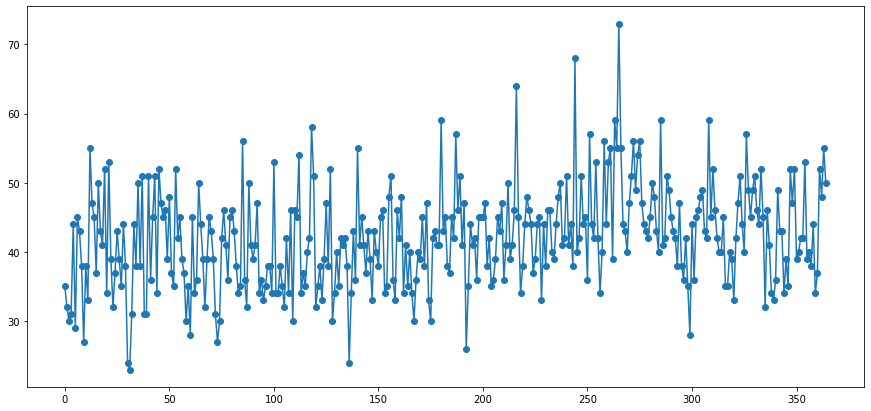

In [7]:
plt.figure(figsize=(15,7))
plt.plot(values, marker='o')
plt.show()

In [18]:
# Transform the time series into supervised learning

data = series_to_supervised(values, n_in=6)

In [11]:
data

array([[35., 32., 30., ..., 44., 29., 45.],
       [32., 30., 31., ..., 29., 45., 43.],
       [30., 31., 44., ..., 45., 43., 38.],
       ...,
       [40., 38., 44., ..., 37., 52., 48.],
       [38., 44., 34., ..., 52., 48., 55.],
       [44., 34., 37., ..., 48., 55., 50.]])

In [19]:
# Evaluate

mae, y, yhat = walk_forward_validation(data, 12)


>expected=42.0, predicted=44.5
>expected=53.0, predicted=42.5
>expected=39.0, predicted=40.3
>expected=40.0, predicted=32.5
>expected=38.0, predicted=41.1
>expected=44.0, predicted=45.3
>expected=34.0, predicted=40.2
>expected=37.0, predicted=35.0
>expected=52.0, predicted=32.5
>expected=48.0, predicted=41.4
>expected=55.0, predicted=46.6
>expected=50.0, predicted=47.2


In [20]:
print('MAE: ', mae)

MAE:  5.956648190816243


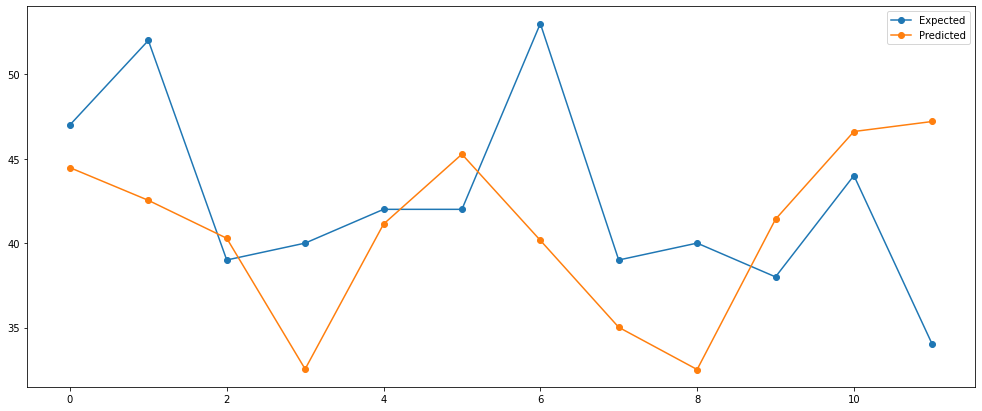

In [21]:
# Plot expected vs predicted

plt.figure(figsize=(17,7))
plt.plot(y, label = 'Expected', marker = 'o')
plt.plot(yhat, label = 'Predicted', marker = 'o')
plt.legend()
plt.show()

In [ ]:
def xgboost_multi_forecast(train, testX, n_steps):
    """
    Ajusta un modelo XGBoost y realiza una predicción de múltiples pasos.
    Argumentos:
        train: Conjunto de datos de entrenamiento.
        testX: Entrada para la cual hacer la predicción.
        n_steps: Número de pasos de tiempo a predecir.
    Devuelve:
        Una lista de predicciones de múltiples pasos para testX.
    """
    # Transforma la lista en una matriz
    train = np.asarray(train)
    
    # Divide en columnas de entrada y salida
    trainX, trainy = train[:, :-1], train[:, -1]
    
    # Ajusta el modelo
    model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
    model.fit(trainX, trainy)
    
    # Inicializa la lista de predicciones
    predictions = []
    input_data = testX

    for _ in range(n_steps):
        # Realiza una predicción
        yhat = model.predict([input_data])
        # Agrega la predicción a la lista de predicciones
        predictions.append(yhat[0])
        # Actualiza los datos de entrada para incluir la nueva predicción
        input_data = np.append(input_data[1:], yhat[0])

    return predictions
